## Bonus Task 1 (Checking the limits)

### In this code I have checked the extrimities of my approch. The limits are $n=6$ and $m=7$
### It's important to note that even with the circuit optimization (using transpiler) it takes considerable amount of time  
### The algorithm that builds a general circuit that accepts vectors with random values of size $2^{n}$ with $m$ bits in length for each element and finds the states which don't have similar adjacent bits in their binary representation.


#### Instructions

- Since QASM allows to simulate at max 32 qubits, the max limit for $n = 6$ (number of addresses) and $m = 7$ (max number of bits)
- If you are simulating for the $n = 2$ case please take $n = 3$ (Since it is impossible to converge grover's)
- $m > n$ (Which corresponds to low range in comparison to the sampling size and thus random sampling won't work)
- After changing the value of $m$ ar the top in cell 3, Please ensure you make a corresponding change at the bottom of cell 3. To keep the format same. For example if $m = 5$ then the bottom formatting should look like <font color=blue>"'{0:05b}'.format(num)"</font>
- While reading the histogram the bottom refers to unit place i.e. $2^{0}$ 

In [1]:
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.tools.jupyter import *

# Loading your IBM Quantum account
IBMQ.load_account()
IBMQ.providers() # see a list of providers you have access to

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
import numpy as np
import math
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit,  transpile
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_bloch_multivector
# import basic plot tools
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt
import itertools 
import random

In [3]:
#sample preparation
# m > n (else random sampling won't work)

n= 6 #number of address bits required
m = 7 #length of the data in bits     #Also change the value of m (in front of b) at the end of the cell 
input_st = random.sample(range(0,(2**m)-1), 2**n)


mark_1 = 0
mark_2 = 0
for i in range(0,m,2):
    mark_1 = mark_1 + 2**i
for i in range(1,m,2):
    mark_2 = mark_2 + 2**i

#Ensuring we have two solutions in the input array
if mark_1 not in input_st:
    loc =random.randint(0,2**n-1)
    input_st[loc] = mark_1
    
if mark_2 not in input_st:
    loc =random.randint(0,2**n-1)
    input_st[loc] = mark_2 
print('This is the input \n', input_st)
bin_pass = []
for num in input_st:
    bin_pass.append('{0:07b}'.format(num))      #Please change the value infront of b to m 

This is the input 
 [104, 92, 94, 57, 39, 28, 77, 23, 114, 5, 74, 17, 86, 52, 32, 22, 78, 82, 14, 31, 0, 89, 102, 108, 40, 10, 123, 93, 63, 25, 121, 54, 18, 71, 29, 96, 107, 119, 95, 81, 103, 67, 62, 110, 91, 80, 106, 99, 7, 20, 61, 45, 38, 26, 11, 85, 3, 98, 37, 53, 36, 33, 24, 42]


In [4]:
# Defining Oracle which checks for the marked state
def oracle(qc,data,comput,m):
    for i in range(m-1):
        qc.cx(data[i], comput[i])
        qc.cx(data[i+1], comput[i])      

In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [6]:
address = QuantumRegister(n)
data = QuantumRegister(m)
comput = QuantumRegister(m-1)
flag = QuantumRegister(1)
c = ClassicalRegister(n) #measuring address
# c = ClassicalRegister(m) #Checking performance of qRAM
# c = ClassicalRegister(3) #Only measuring the comput and qRAM address
anicilla_qubit = QuantumRegister(m-3)
if n>2:
    qRAM_ancilla = QuantumRegister(n-2)
qc = QuantumCircuit(address,data,qRAM_ancilla,comput,flag,anicilla_qubit,c)
# qc = QuantumCircuit(address,data,qRAM_ancilla,c)

In [7]:
# Calculates required Grover iterations
grov_iter = math.floor((np.pi*np.sqrt(2**n/2))/4)
grov_iter

4

In [8]:
text_list = []
alpha = 'a'
var = []
diff = []
for i in range(n):
    diff.append(i)
for i in range(n):
    text_list.append(alpha)
    alpha = chr(ord(alpha) + 1) 
for x_0 in text_list:
    var.append([0,1])
qc.x(flag[0]) #Flag for qram check
qc.h(flag[0])
for i in range(n):
    qc.h(address[i])
qc.barrier()    
for grov in range(grov_iter):
    
    for text_list in itertools.product(*var):
        summ = 0
        for i in range(n):
            summ = summ + text_list[i]*2**(abs(i-n+1))
            if text_list[i]==0:
                qc.x([address[i]])
        for o in range(m):          
            if bin_pass[summ][o]=='1':
                qc.mct(address,data[o],qRAM_ancilla,mode='basic')
        for j in range(n):
            if text_list[j]==0:
                qc.x([address[j]])
        qc.barrier()
    oracle(qc,data,comput,m)
    qc.barrier()
    qc.mct(comput,flag[0],anicilla_qubit,mode='basic')
    qc.barrier()
    oracle(qc,data,comput,m)
    qc.barrier()        
 
    for text_list in itertools.product(*var):
        summ = 0     
        for i in range(n):
            summ = summ + text_list[i]*2**(abs(i-n+1))
            if text_list[i]==0:
                qc.x([address[i]])
        for o in range(m):          
            if bin_pass[summ][o]=='1':
                qc.mct(address,data[o],qRAM_ancilla,mode='basic')
        for j in range(n):
            if text_list[j]==0:
                qc.x([address[j]])                      
        qc.barrier()
    qc.append(diffuser(n),diff)    
    qc.barrier() 
qc.reverse_bits()
qc.measure(address[:], c)

In [9]:
qc.draw(output='mpl')

ValueError: Image size of 1604x250997 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1604.87x250998 with 1 Axes>

In [10]:
backend = Aer.get_backend('qasm_simulator')

print('Circuit Depth before Optimization:', qc.depth())
print('Gate counts before Optimization: {}\n'.format(qc.count_ops()))
for kk in range(3):
    new_cirq = transpile(qc, backend, optimization_level=kk)
    print('Optimization Level {}'.format(kk))
    print('Circuit Depth:', new_cirq.depth())
    print('Gate counts:', new_cirq.count_ops())
    print()
# new_cirq.draw(output='mpl')

Circuit Depth before Optimization: 2923
Gate counts before Optimization: OrderedDict([('x', 3073), ('mcx_vchain', 1812), ('barrier', 529), ('cx', 96), ('h', 7), ('measure', 6), ('$U_s$', 4)])

Optimization Level 0
Circuit Depth: 110675
Gate counts: OrderedDict([('cx', 43584), ('h', 29055), ('t', 28992), ('tdg', 28992), ('x', 3121), ('ccx', 1812), ('barrier', 529), ('measure', 6), ('mcx_gray', 4)])

Optimization Level 1
Circuit Depth: 27322
Gate counts: OrderedDict([('cx', 12288), ('u2', 8169), ('tdg', 4064), ('t', 4064), ('x', 3008), ('ccx', 1812), ('barrier', 529), ('u1', 8), ('h', 6), ('measure', 6), ('mcx_gray', 4)])

Optimization Level 2
Circuit Depth: 27322
Gate counts: OrderedDict([('cx', 12288), ('u2', 8169), ('tdg', 4064), ('t', 4064), ('x', 3008), ('ccx', 1812), ('barrier', 529), ('u1', 8), ('h', 6), ('measure', 6), ('mcx_gray', 4)])



C:\Users\sumit\Miniconda3\envs\penny\lib\site-packages\qiskit\execute_function.py:343: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = backend.run(experiments, **run_kwargs)


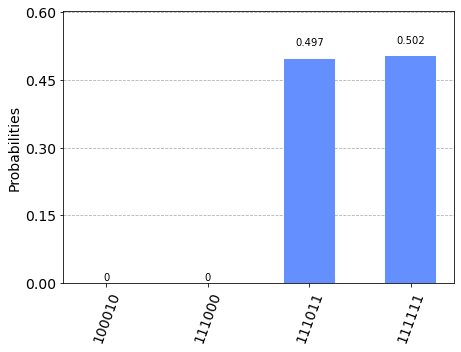

In [11]:
job = execute(new_cirq, backend=backend, shots=2048, seed_simulator=4096, backend_options={"fusion_enable":True})

result = job.result()
count =result.get_counts()
plot_histogram(result.get_counts())

In [17]:
print('This is the input state:\n\n',input_st)
print('\nThis is binary conversion of the solutions\t:''{0:08b}'.format(170),'\t','{0:08b}'.format(85))
print('\nLocation of solution 42\t:',input_st.index(42),'\t','Location of solution 85\t:',input_st.index(85))

This is the input state:

 [104, 92, 94, 57, 39, 28, 77, 23, 114, 5, 74, 17, 86, 52, 32, 22, 78, 82, 14, 31, 0, 89, 102, 108, 40, 10, 123, 93, 63, 25, 121, 54, 18, 71, 29, 96, 107, 119, 95, 81, 103, 67, 62, 110, 91, 80, 106, 99, 7, 20, 61, 45, 38, 26, 11, 85, 3, 98, 37, 53, 36, 33, 24, 42]

This is binary conversion of the solutions	:10101010 	 01010101

Location of solution 42	: 63 	 Location of solution 85	: 55


In [13]:
print(count)


{'111011': 1018, '111111': 1028, '111000': 1, '100010': 1}
